In [70]:
# Import Library

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [71]:
# Connect with google drive (Keep data file)

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [72]:
# Read data

path = '/content/gdrive/MyDrive/BAD7105-CRM-Analytics/HW02 Customer Segmentation/Supermarket Data.csv'
data = pd.read_csv(path)
data['SHOP_DATE'] = data['SHOP_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [73]:
#Check data
pd.options.display.max_columns = 10
data.head(10)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,...,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200732,2007-10-05,6,17,3,...,Top Up,Grocery,STORE00001,LS,E02
1,200733,2007-10-10,4,20,3,...,Full Shop,Fresh,STORE00001,LS,E02
2,200741,2007-12-09,1,11,1,...,Full Shop,Grocery,STORE00001,LS,E02
3,200731,2007-09-29,7,17,1,...,Full Shop,Mixed,STORE00001,LS,E02
4,200737,2007-11-10,7,14,3,...,Full Shop,Fresh,STORE00001,LS,E02
5,200746,2008-01-08,3,15,1,...,Top Up,Fresh,STORE00001,LS,E02
6,200731,2007-09-29,7,18,1,...,Full Shop,Fresh,STORE00001,LS,E02
7,200732,2007-10-04,5,21,3,...,Small Shop,Fresh,STORE00001,LS,E02
8,200738,2007-11-16,6,18,3,...,Top Up,Fresh,STORE00001,LS,E02
9,200738,2007-11-15,5,15,3,...,Full Shop,Fresh,STORE00001,LS,E02


In [74]:
# Convert transaction data to customer single view

data_csv = data[data['CUST_CODE'].notnull()].groupby('CUST_CODE').agg(TotalSpend=('SPEND', 'sum'),
                                                           TotalVisits=('BASKET_ID', 'nunique'),
                                                           TotalProd=('PROD_CODE', 'nunique'),
                                                           SHOP_WEEKDAYS=('SHOP_WEEKDAY',lambda x: stats.mode(x)[0][0]),
                                                           SHOP_HOURS = ('SHOP_HOUR',lambda x: stats.mode(x)[0][0]),
                                                           BASKET_DOMINANT = ('BASKET_DOMINANT_MISSION',lambda x: stats.mode(x)[0][0])
                                                           ).reset_index()
data_csv['TicketSize'] = data_csv['TotalSpend']/data_csv['TotalVisits']
data_csv['BASKET_DOMINANT'].replace({'Grocery':0,'Fresh':1,'Mixed':2,'Nonfood':3,'XX':4},inplace=True) 
data_csv = data_csv.drop(columns=['CUST_CODE'])  

data_csv.head(10)

,TotalSpend,TotalVisits,TotalProd,SHOP_WEEKDAYS,SHOP_HOURS,BASKET_DOMINANT,TicketSize
0,2.44,1,1,7,13,1,2.440000
1,959.33,220,189,6,17,1,4.360591
2,328.57,16,116,2,21,2,20.535625
3,5.95,3,4,1,8,0,1.983333
4,39.74,4,24,1,16,1,9.935000
5,2493.83,103,403,6,19,1,24.211942
6,1.99,1,1,6,13,3,1.990000
7,0.34,1,1,6,10,1,0.340000
8,1.80,6,1,5,10,0,0.300000
9,124.63,15,53,2,14,1,8.308667


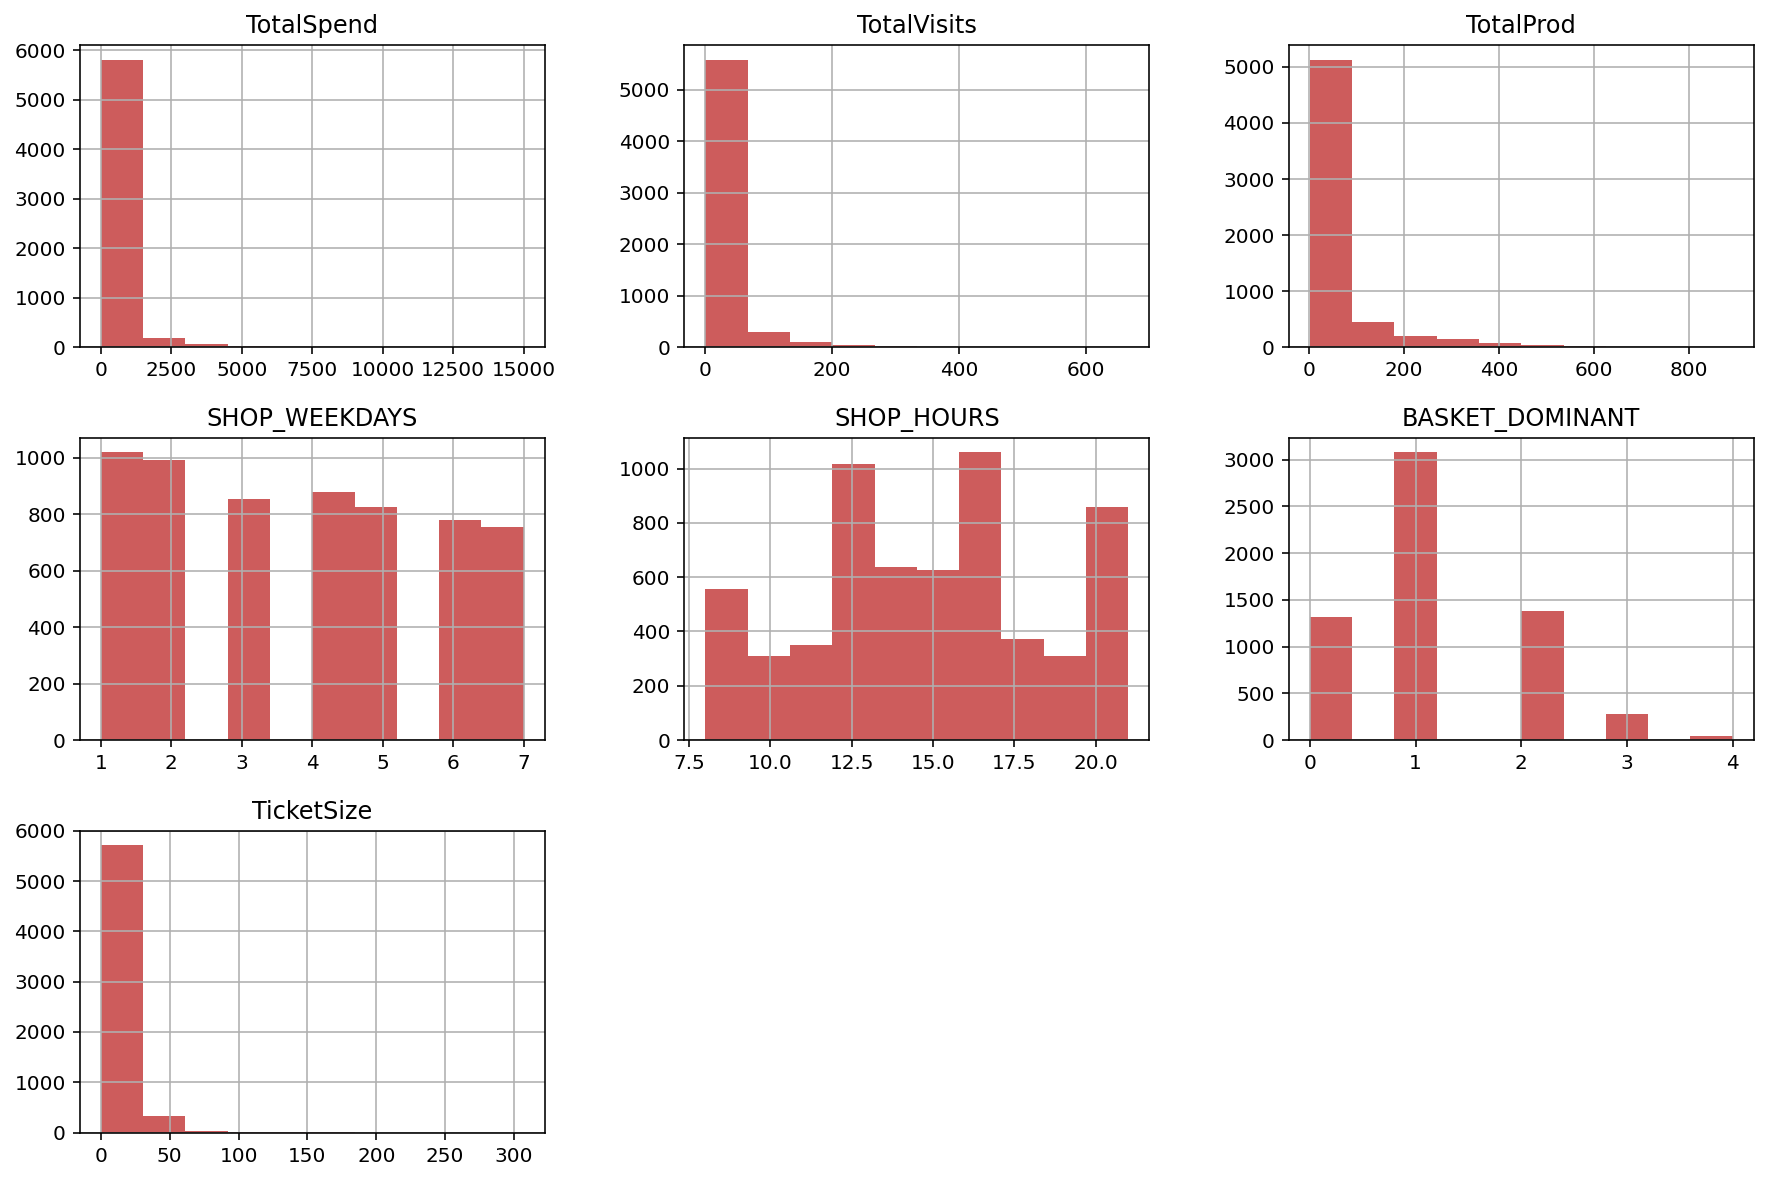

In [75]:
# Explore data
# data_csv['TicketSize'].plot.hist(color='indianred')
data_csv.hist(figsize=(15,10),color='indianred')
plt.savefig('explor.png',dpi=300)
plt.show()

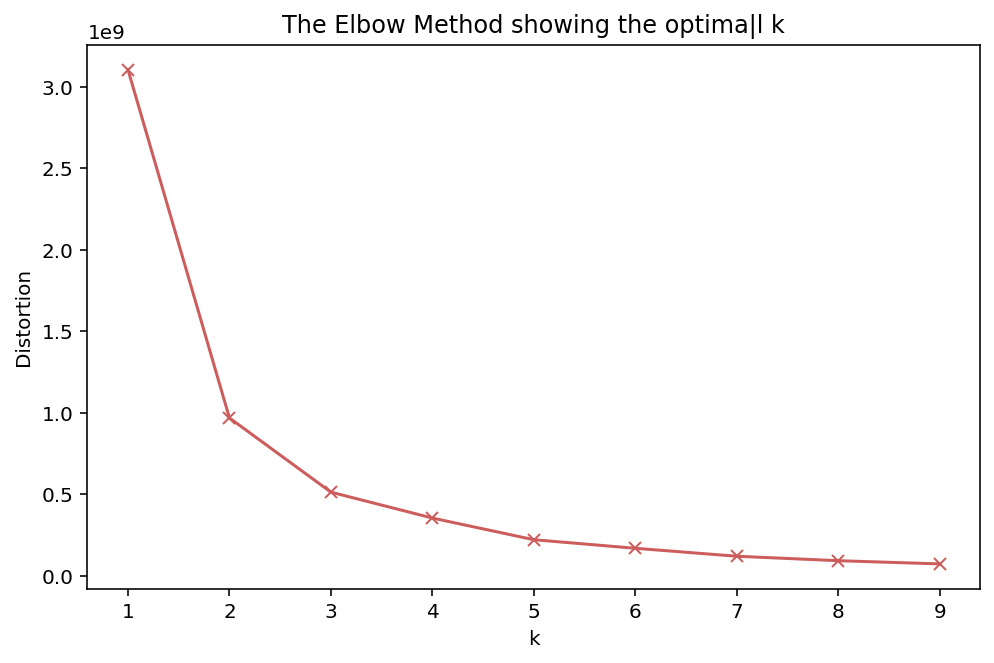

In [76]:
# Elbow plot

distortions = []
K = range(1,10)
for k in K:
  model = KMeans(n_clusters=k)
  model.fit(data_csv)
  distortions.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'x-',color='indianred')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optima|l k')
plt.savefig('elbow.png',dpi=300)
plt.show()

In [77]:
# Kmena select K = 4

model = KMeans(n_clusters=4)
model.fit(data_csv)

KMeans(n_clusters=4)

In [78]:
data_csv['Group'] = model.predict(data_csv)
data_csv.head()

,TotalSpend,TotalVisits,TotalProd,SHOP_WEEKDAYS,SHOP_HOURS,BASKET_DOMINANT,TicketSize,Group
0,2.44,1,1,7,13,1,2.440000,1
1,959.33,220,189,6,17,1,4.360591,0
2,328.57,16,116,2,21,2,20.535625,1
3,5.95,3,4,1,8,0,1.983333,1
4,39.74,4,24,1,16,1,9.935000,1


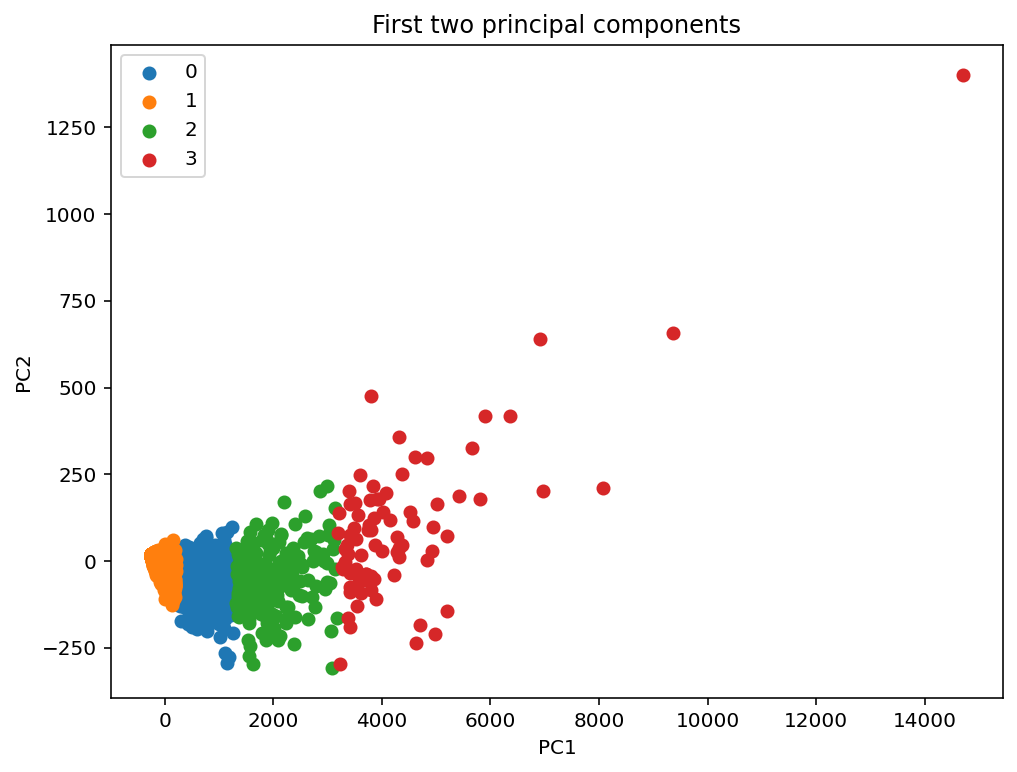

In [79]:
#PCA plot
X = data_csv.drop(columns=['Group'])
y = data_csv['Group']

pca = PCA()
Xt = pca.fit_transform(X)

plt.figure(figsize=(8,6))
Xt = pca.fit_transform(X)
df_pca = pd.DataFrame()
df_pca['PCA1'] = Xt[:,0]
df_pca['PCA2'] = Xt[:,1]
df_pca['y'] = y
for label in np.unique(y):
    plt.scatter(df_pca[y==label]['PCA1'], df_pca[y==label]['PCA2'], label=label)
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components")
plt.savefig('custer.png',dpi=300)
plt.show()

In [80]:
#Tree

model = DecisionTreeClassifier(max_depth = 4,random_state = 9)
model.fit(X,y)

DecisionTreeClassifier(max_depth=4, random_state=9)

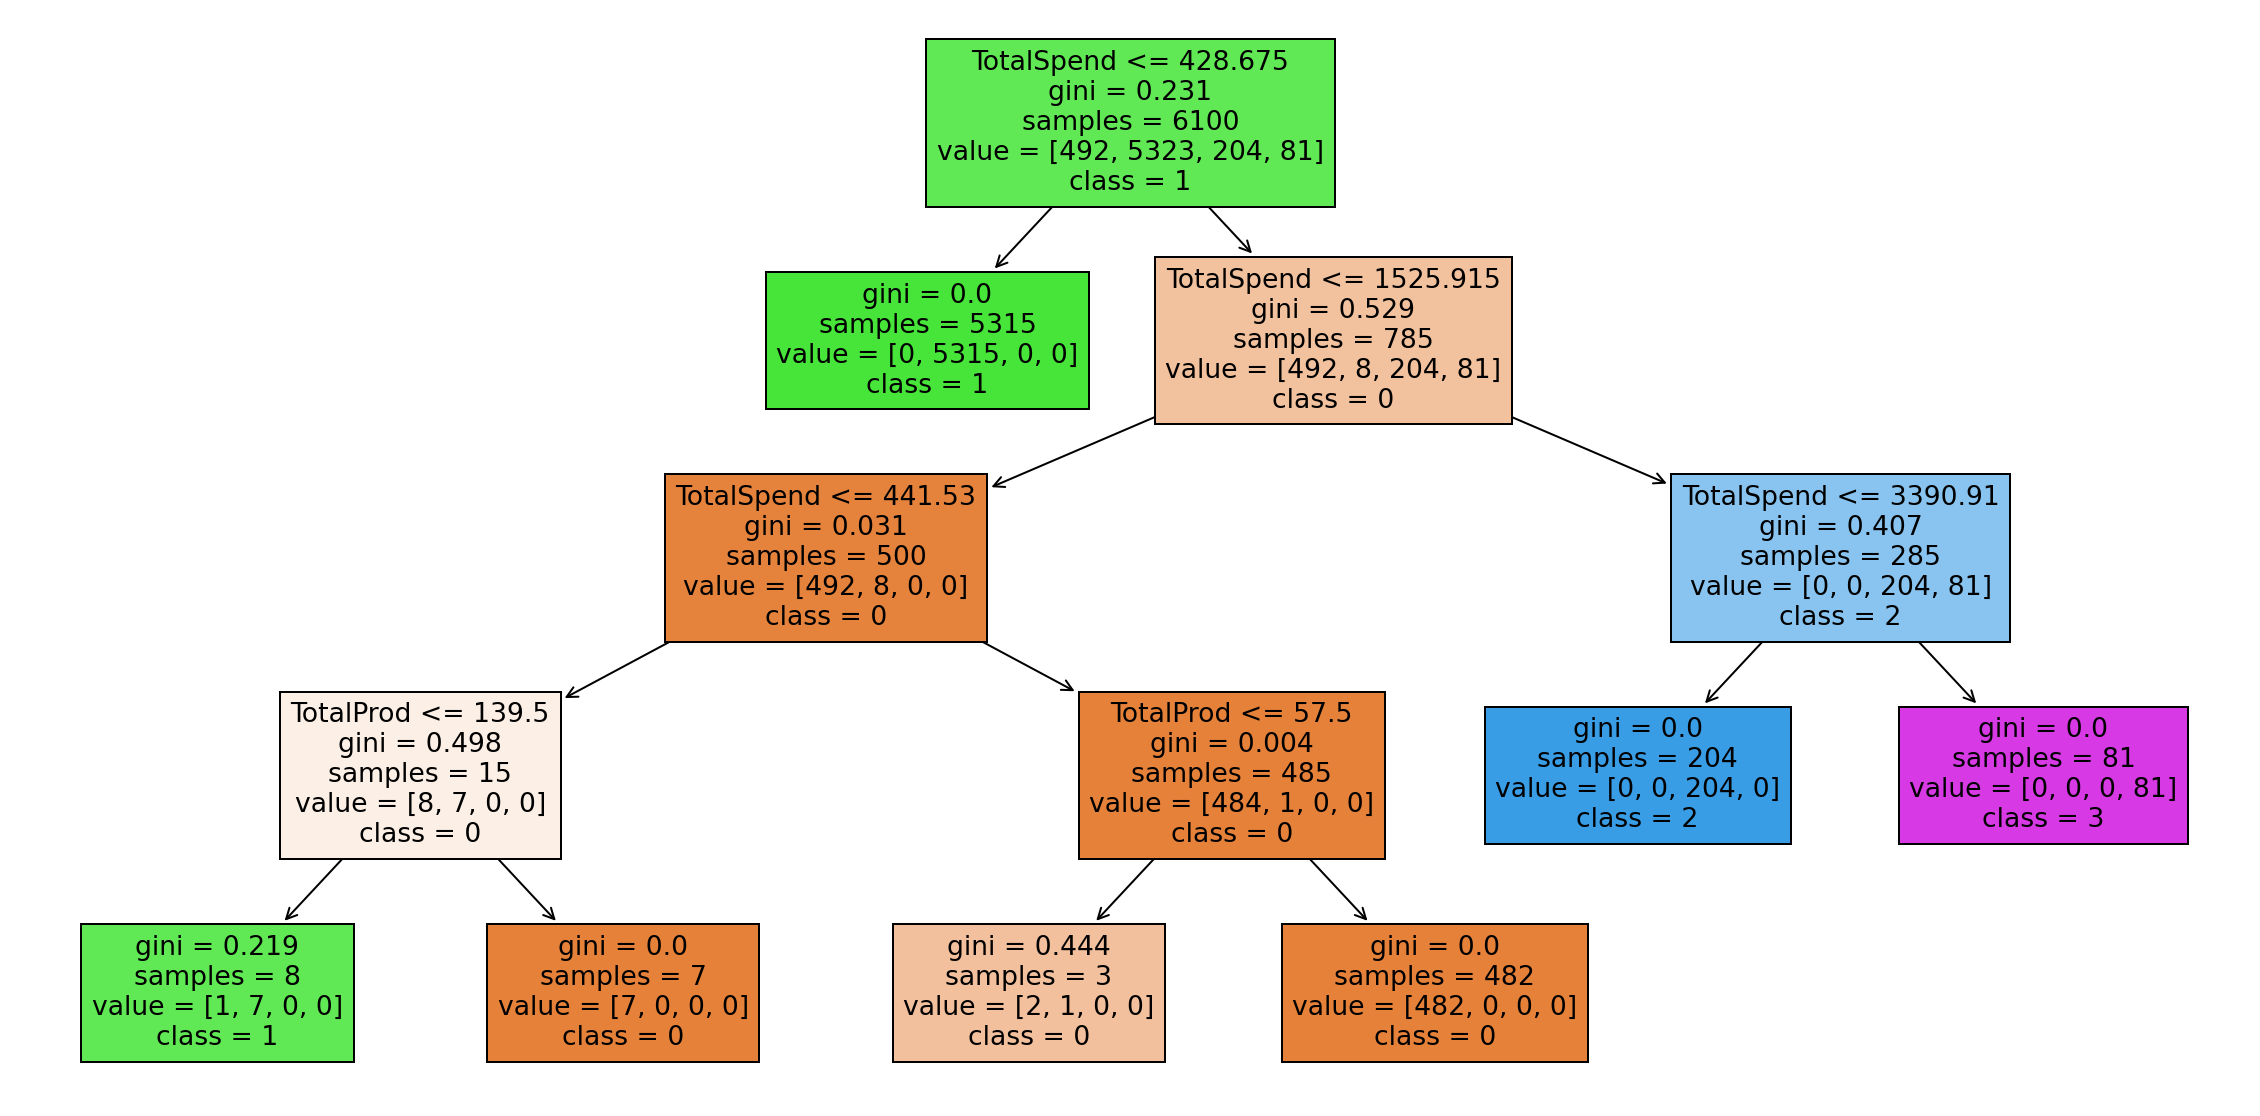

In [81]:
#Plot Tree

plt.figure(figsize=(20,10))
tree.plot_tree(model,feature_names=X.columns,class_names=model.classes_.astype(str),filled=True)
plt.savefig('tree.png',dpi=300)
plt.show()

In [83]:
#Descriptive Statistics by Group

data_csv.groupby('Group').agg(TotalSpend=('TotalSpend','mean'),
                              TotalVisits=('TotalVisits','mean'),
                              TotalProd=('TotalProd','mean'),
                              SHOP_WEEKDAYS=('SHOP_WEEKDAYS',lambda x: stats.mode(x)[0][0]),
                              SHOP_HOURS=('SHOP_HOURS',lambda x: stats.mode(x)[0][0]),
                              BASKET_DOMINANT=('BASKET_DOMINANT',lambda x: stats.mode(x)[0][0]),
                              TicketSize=('TicketSize','mean'))

,TotalSpend,TotalVisits,TotalProd,SHOP_WEEKDAYS,SHOP_HOURS,BASKET_DOMINANT,TicketSize
Group,,,,,,,
0,833.066931,76.168699,186.709350,2,21,1,17.904833
1,50.104574,6.373098,18.581627,1,15,1,8.813749
2,2222.132402,151.323529,349.980392,4,21,1,19.726205
3,4579.544444,245.790123,498.395062,5,13,1,23.501962


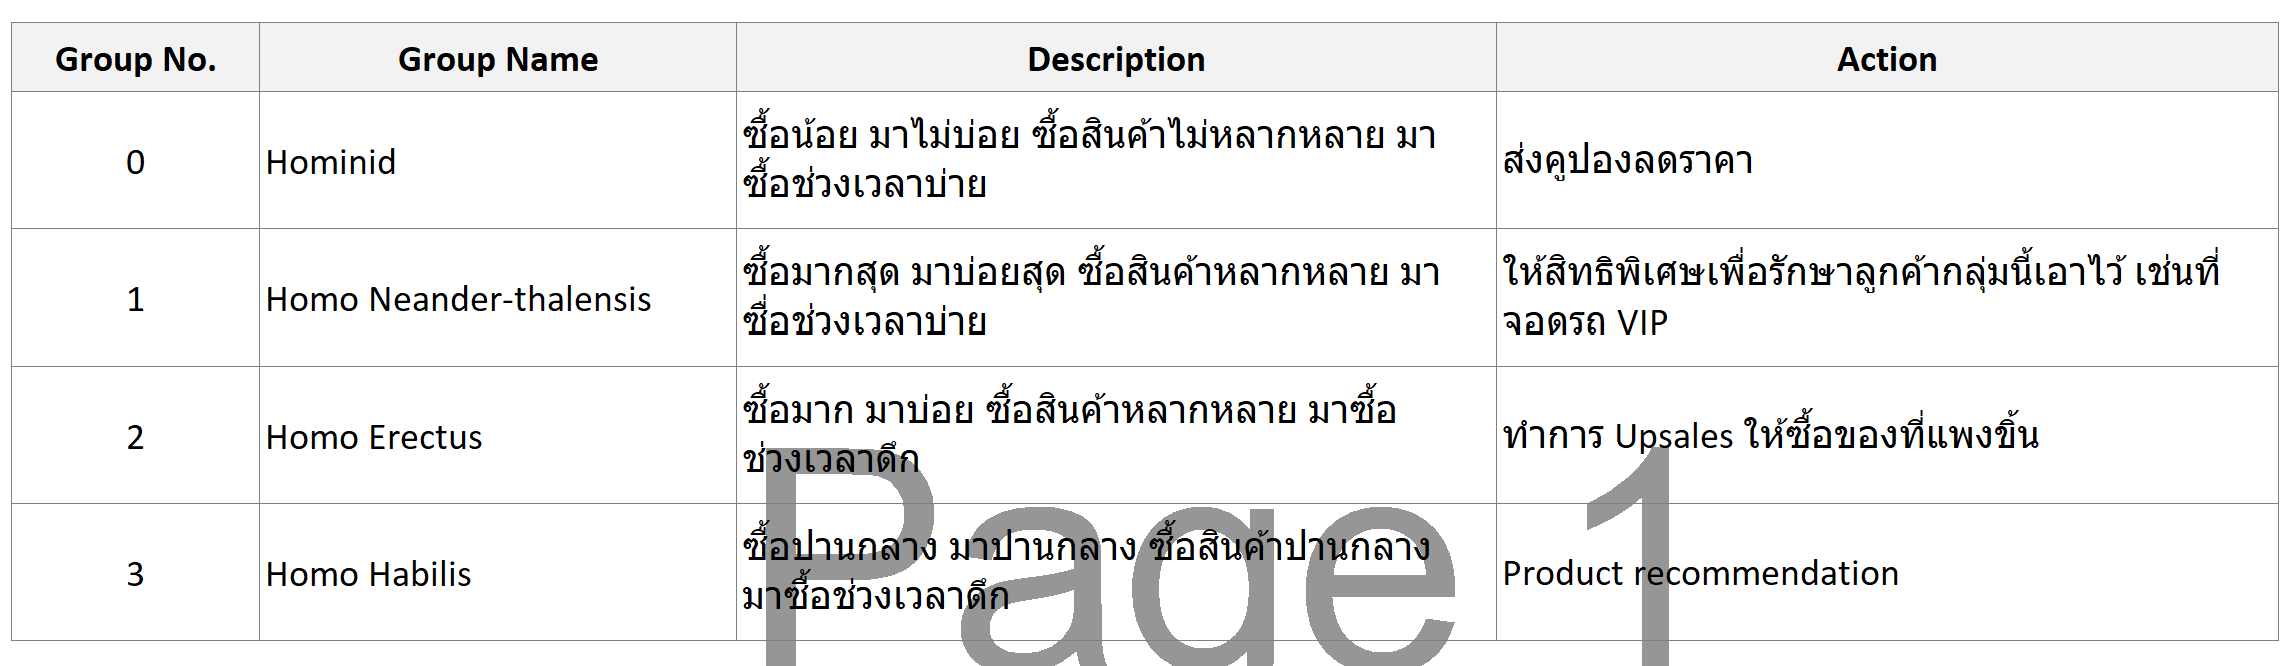